### Example notebook for WorkStation - Differential Gene Expression (Pathway Enrichment)

This notebook demonstrates reading from API and performing analysis of differential gene expression.
- title: "DGE-Pathways"
- author: "Margaret Paiva"
- author: "Jon Katz"
- date: "19/10/2021"
- output: R notebook

In [17]:
# Check your R version if packages are not compatible
R.version

In [4]:
# Install BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

In [3]:
# Install packages using BiocManager
for (pkg in c("limma", "fgsea")) {
    if (!requireNamespace(pkg, quietly = TRUE)) {
        BiocManager::install(pkg, update = FALSE, 
                             ask = FALSE, force = TRUE)
    }
}

In [2]:
suppressPackageStartupMessages(library(jsonlite))
suppressPackageStartupMessages(library(rjson))
suppressPackageStartupMessages(library(httr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(parallel))
suppressPackageStartupMessages(library(DBI))
suppressPackageStartupMessages(library(DT))
suppressPackageStartupMessages(library(limma))
suppressPackageStartupMessages(library(fgsea))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))

Request data from API if it is not done yet.

In [33]:
# In "gene_list.csv", define a list of genes of interest
gene_list  <- as.list(read.csv("gene_list.csv")$x)
gene_list[1:2]

[[1]]
[1] AGR2
400 Levels: A1BG A4GALT ABCA3 ABCC3 ABCG1 ABLIM2 ABLIM3 ACE ACKR3 ACOX2 ... FOXC1

[[2]]
[1] CEACAM6
400 Levels: A1BG A4GALT ABCA3 ABCC3 ABCG1 ABLIM2 ABLIM3 ACE ACKR3 ACOX2 ... FOXC1

In [34]:
# Define the data to query from API
data  <- list("request_data_type" = "expression",
              # If only pathway enrichment analysis is needed, you may request only one cancer type
              # to see what pathways are enriched for a specific cancer type
  "request_cancer_type" = c("Renal cell carcinoma", "Prostate", "Adenoid cystic carcinoma", "Breast", 
                            "Thyroid", "Testicular", "Hepatocellular carcinoma", "Melanoma"),
#   "request_genes" = c("ATM", "BRCA1", "BRCA2", "BRIP1", "CDK12", "FANCA", "HDAC2", "KRAS", 
#                       "PALB2", "SRY", "TP53", "NOTCH1", "CCND1", "BARD1", "FBLN2", "CDKN1B", 
#                       "RB1", "CHEK2", "APOBEC3B", "PALB2"),  # to define a list of genes here
  "request_genes" = gene_list,  # if a list of genes is defined in a file
  "request_dataset" = "PDX",
  "request_key" = "a3208f8f73654023bd0f267eb9d014bb",
  "request_client" = 99,
  "request_user" = 99,
  "request_mode" = 'true') 

In [35]:
# Request data from API - this may take some time
request  <-  POST(url = 'https://lumin-fast-api.championsoncology.com/workstation', 
                  body = data, encode = 'json')
request
# A successful request will give "Status: 200"

Response [https://lumin-fast-api.championsoncology.com/workstation]
  Date: 2021-10-19 20:52
  Status: 200
  Content-Type: application/json
  Size: 75 B


In [36]:
# This will save the data file as a .json file in your root directory
response <- content(request)
response

[1] "success, the file you may view your requested data in your root directory"

In [52]:
# Enter the file name of the .json file in your root directory below
lt  <-  fromJSON(file = "./data/requested_data---19-10-2021---20_44_20.json")

In [53]:
# Create a dataframe from the data
df  <- do.call(rbind, lapply(lt, rbind))
df  <- as.data.frame(df)
df$gene  <- as.character(df$gene)  # each column is a list - specify data type
df$model  <- as.character(df$model)
df$log.tpm  <- as.numeric(df$log.tpm)
df$z  <- as.numeric(df$z)
head(df, 2)
print(dim(df))

v1,gene_id,log.rsem.rpkm,log.tpm,z,fold,trans,model,sort_key,gene,model_name,tumor_type
19463231,ENSG00000005187,2.03154538924124,2.7411490,-0.1693172,0.876569685689051,ENST00000440284:49.26% ENST00000567387:17.78% ENST00000501740:11.52% ENST00000289416:10.09%,CTG-3501,CTG-3501_Expression_1,ACSM3,CTG-3501,Breast
19463234,ENSG00000005243,0.43494348437293,0.7995996,-0.9946150,0.185174375597962,ENST00000006101:78.76% ENST00000579263:20.8%,CTG-3501,CTG-3501_Expression_1,COPZ2,CTG-3501,Breast


[1] 82800    12


### GSEA pathway enrichment analysis

I load an object previously generated here. The only file needed besides the API data above is pathways.gmt. You can download it from https://www.pathwaycommons.org/.

In [12]:
load("../data/RData_uncomp_20210714", verbose=TRUE)

Loading objects:
  cnv.db
  lcpm.list
  lrpkm.lst
  mut.db
  pathways.gmt
  pathways_namming
  rna.seq
  rna.seq.heme
  symbols.dt


To use GSEA for pathway enrichment analysis, a ranking data with genes ranked by the t or z statistics must be provided. Here, we can extract the statistics from the API data. For your own research, you can calculate the t statistics between genes using the `log.tpm` column of the API data.

In [54]:
ranks <- df %>% 
  dplyr::select(gene, z) %>% 
  na.omit() %>%
  deframe()
head(ranks, 2)

ACSM3      COPZ2 
-0.1693172 -0.9946150

Now, we have everything we need to perform pathway enrichment analysis.

In [55]:
fgseaRes <- suppressWarnings(fgsea(pathways = pathways.gmt,
     stats = ranks,
     nperm = 1000))
head(fgseaRes, 2)

pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
http://identifiers.org/kegg.pathway/hsa00010,0.14717742,0.16200104,0.8098988,1.317346,72,2,"FBP1 , ALDH3A1"
http://identifiers.org/kegg.pathway/hsa00030,0.03333333,0.04126214,0.9808693,1.307532,15,1,FBP1


- ES – enrichment score
- NES – normalized enrichment score

In [56]:
# Rank the pathways by the normalized enrichment scores
fgseaResTidy <- fgseaRes %>%
  as_tibble() %>%
  arrange(desc(NES))

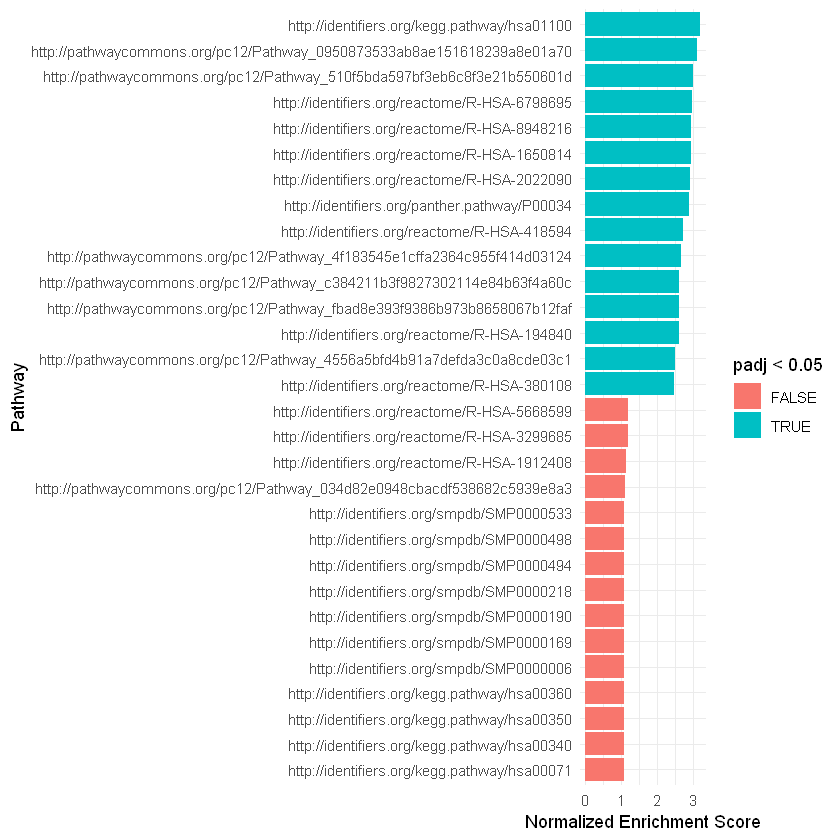

In [58]:
# Here, I rbind the top pathways and the bottom pathways to show the significant vs. the non-significant pathways
# You may want to pick only the top pathways to explore further
ggplot(rbind(head(fgseaResTidy, 15), tail(fgseaResTidy, 15)), 
       aes(reorder(pathway, NES), NES)) +
  geom_col(aes(fill=padj<0.05)) +
  coord_flip() +
  labs(x="Pathway", y="Normalized Enrichment Score") + 
  theme_minimal()